### AirBnB Scraping

In [2]:
%matplotlib inline

import pylab as plt
import numpy as np
import pandas as pd
import operator
import seaborn as sns
import time
from pyquery import PyQuery as pq
import requests
import re

In [3]:
res = requests.get('http://www.airbnb.com/rooms/1828361')
res.content

'<!DOCTYPE html>\n\n<!--[if lt IE 8]>\n\n<html lang="en"\n      \n      xmlns:fb="http://ogp.me/ns/fb#"\n      class="ie">\n\n<![endif]-->\n\n<!--[if IE 8]>\n\n<html lang="en"\n      \n      xmlns:fb="http://ogp.me/ns/fb#"\n      class="ie ie8">\n\n<![endif]-->\n\n<!--[if IE 9]>\n\n  <html lang="en"\n      \n      xmlns:fb="http://ogp.me/ns/fb#"\n      class="ie ie9">\n\n<![endif]-->\n\n<!--[if (gt IE 9)|!(IE)]><!-->\n<html lang="en"\n      \n      xmlns:fb="http://ogp.me/ns/fb#">\n\n<!--<![endif]-->\n\n  <head>\n      <link rel="dns-prefetch" href="//maps.googleapis.com">\n      <link rel="dns-prefetch" href="//maps.gstatic.com">\n      <link rel="dns-prefetch" href="//mts0.googleapis.com">\n      <link rel="dns-prefetch" href="//mts1.googleapis.com">\n\n    <!--[if IE]><![endif]-->\n    <meta charset="utf-8">\n\n    <!--[if IE 8]>\n      <link href="https://a1.muscache.com/airbnb/static/packages/common_o2.1_ie8-6a69280afbba36d5f7780a547b0c1e7c.css" media="all" rel="stylesheet" type="

In [14]:
# Try to connect

try:
    conn = psycopg2.connect(database='pulse', user='postgres', password='ronnie', host='localhost', port="5432")
except:
    print "I am unable to connect to the database."
    
cur = conn.cursor()
try:
    cur.execute("select * from listing")
except:
    print "I can't drop our test database!"
    
rows = cur.fetchall()
print rows

I am unable to connect to the database.


NameError: name 'conn' is not defined

In [14]:
cListURL = "https://boston.craigslist.org/search/gbs/nfa?max_price=2000&query=private+entrance&hasPic=1&min_price=1000"
airURLBoston = "http://www.airdna.co/city/us/massachusetts/boston/top"
airURLCambridge = "http://www.airdna.co/city/us/massachusetts/cambridge/top"

In [8]:
response = [requests.get(airURLBoston), requests.get(airURLCambridge)]

In [6]:
def returnAirDetails(url):
    # scrape airbnb listing page
    listingResponse = requests.get(url)
    lDoc = pq(listingResponse.content)
    
    # get content from airbnb pages
    aTitle = lDoc('title').text()
    aLongitude = lDoc('meta[property="airbedandbreakfast:location:longitude"]').attr('content')
    aLatitude = lDoc('meta[property="airbedandbreakfast:location:latitude"]').attr('content')
    aLocation = ''
    
     # regex to find neighborhood
    reg = "eighborhood&quot;:&quot;([a-zA-Z _-]+)"
    locReg = re.search(reg, listingResponse.content)
    if(bool(locReg)):  
        aLocation = locReg.groups()[0]

    return aTitle, aLongitude, aLatitude, aLocation
    

In [9]:
airArray = []
locs = {}
airFrame = pd.DataFrame(columns=['url', 'type', 'review_count', 'title', 'location', 'longitude', 'latitude'])
af = 0

for r in response:
    doc = pq(r.content)
    topTable = doc('div.row table')
    airRow = pq(topTable('tr'))
    
    #start at second row to avoid header row
    for airRow in airRow[1:]:
        aURL = pq(airRow).find('a').attr('href')
        aType = pq(airRow).find('td').eq(2).text()
        aReviews = pq(airRow)('td').eq(4).text()
        
        time.sleep(2) # wait just one second, buddy
        aTitle, aLongitude, aLatitude, aLocation = returnAirDetails(aURL)
        
        if(aLocation not in locs):
            locs[aLocation] = 0

        locs[aLocation] = locs[aLocation] + 1
        
        airFrame.loc[af] = [aURL, aType, aReviews, aTitle, aLocation, aLongitude, aLatitude]
     
        af += 1
    
    
#print airArray

To CSV

In [17]:
airFrame.to_csv("data/airdata.csv", sep=',')

In [11]:
airFrame

,url,type,review_count,title,location,longitude,latitude
0,https://www.airbnb.com/rooms/414419,Entire Place,239,Back Bay! Best Location in Boston! - Lofts for...,Back Bay,-71.08169858052565,42.3533625963596
1,https://www.airbnb.com/rooms/10745,Private Room,378,JazzVille: Bn'B Boston & Cambridge - Bed & Bre...,Cambridge,-71.10652076483046,42.362987909136415


Bar chart shoring popularity of each neighborhood:

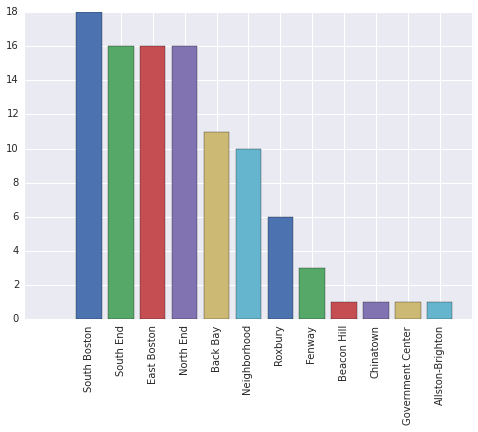

In [135]:
current_palette = sns.color_palette()
sortedLocs = {}
df = pd.DataFrame(locs)

df.columns = ['Neighborhood', 'Count']
df = df.sort('Count', ascending=0)
df = df.reset_index()

X = np.arange(0, len(df.index))

plt.bar(df.index, df['Count'], color=current_palette , align='center')

plt.xticks(df.index, df['Neighborhood'], rotation='vertical')
plt.show()